<a href="https://colab.research.google.com/github/martinkenas/Road-Segmentation-for-type-wetness-and-roughness/blob/main/model_training_scripts/Kelio_tipas_YOLOv8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title PILNAS TIPO 1. Sąranka ir diegimas

# Įdiegiame būtinas bibliotekas
!pip install ultralytics

# Importuojame reikalingas bibliotekas
import os
import yaml
import shutil
import random
from IPython.display import display, Image
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as PILImage
import cv2
from google.colab import drive
from datetime import datetime
import torch
from sklearn.model_selection import train_test_split

# Prijungiame Google Drive
drive.mount('/content/drive')

print("Sąranka baigta!")



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 746.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
#@title 2. Projekto struktūros konfigūravimas

import os
import yaml
import random
import shutil
from datetime import datetime
from PIL import Image as PILImage
from sklearn.model_selection import train_test_split

# Baziniai katalogai kelio dangos segmentacijai
base_dir = '/content/drive/MyDrive/Dangos Tipo Nustatymas'
print(f"Pagrindinis katalogas: {base_dir}")

# Šaltinių katalogai maskuotiems vaizdams ir žymėms
images_dir = os.path.join(base_dir, 'Images(kaukes)')
labels_dirs = {
    'asfaltas': os.path.join(base_dir, 'labels', 'asfaltas'),
    'zvyras': os.path.join(base_dir, 'labels', 'zvyras'),
    'grindinys': os.path.join(base_dir, 'labels', 'grindinys')
}

# Sukuriame laiko žymą unikaliam projekto paleidimui
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
project_dir = os.path.join(base_dir, f'road_type_seg_{timestamp}')
os.makedirs(project_dir, exist_ok=True)

# Rezultatų katalogai
results_dir = os.path.join(project_dir, 'results')
predictions_dir = os.path.join(project_dir, 'predictions')
exports_dir = os.path.join(project_dir, 'exports')
os.makedirs(results_dir, exist_ok=True)
os.makedirs(predictions_dir, exist_ok=True)
os.makedirs(exports_dir, exist_ok=True)

# Sukuriame duomenų rinkinio katalogų struktūrą
dataset_root = os.path.join(base_dir, f'road_type_dataset_{timestamp}')
os.makedirs(dataset_root, exist_ok=True)

# Sukuriame YOLO duomenų rinkinio struktūrą
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(dataset_root, 'images', split), exist_ok=True)
    os.makedirs(os.path.join(dataset_root, 'labels', split), exist_ok=True)


Pagrindinis katalogas: /content/drive/MyDrive/Dangos Tipo Nustatymas


In [ ]:
#@title 3. Duomenų rinkinio analizė ir padalijimų sukūrimas

def analyze_dataset():
    """Analizuoti duomenų rinkinį ir sukurti padalijimus"""
    # Gauname visus pažymėtus failus iš kiekvieno katalogo
    all_files = {}

    # Skaičiuojame failus kiekvienam dangos tipui
    type_counts = {}

    for pavement_type, label_dir in labels_dirs.items():
        files = []
        class_id = {"asfaltas": 0, "zvyras": 1, "grindinys": 2}[pavement_type]

        # Gauname visus txt failus, išskyrus classes.txt
        for file in os.listdir(label_dir):
            if file.endswith('.txt') and file != 'classes.txt':
                base_name = os.path.splitext(file)[0]
                # Tikriname, ar egzistuoja atitinkamas vaizdas
                img_path = None
                for ext in ['.jpg', '.jpeg', '.png']:
                    if os.path.exists(os.path.join(images_dir, base_name + ext)):
                        img_path = os.path.join(images_dir, base_name + ext)
                        break

                if img_path:
                    files.append({
                        'base_name': base_name,
                        'img_path': img_path,
                        'label_path': os.path.join(label_dir, file),
                        'pavement_type': pavement_type,
                        'class_id': class_id
                    })

        all_files[pavement_type] = files
        type_counts[pavement_type] = len(files)

    # Spausdiname statistiką
    print("\nDuomenų rinkinio statistika:")
    total_files = sum(type_counts.values())
    for pavement_type, count in type_counts.items():
        print(f"  {pavement_type}: {count} failai ({count/total_files*100:.1f}%)")
    print(f"  Iš viso: {total_files} failai")

    # Sukuriame padalijimus (70% train, 15% val, 15% test)
    splits = {'train': [], 'val': [], 'test': []}

    for pavement_type, files in all_files.items():
        # Padalijame failus
        train_files, temp = train_test_split(
            files, test_size=0.3, random_state=42
        )
        val_files, test_files = train_test_split(
            temp, test_size=0.5, random_state=42
        )

        # Pridedame į padalijimus
        splits['train'].extend(train_files)
        splits['val'].extend(val_files)
        splits['test'].extend(test_files)

    # Spausdiname padalijimų statistiką
    print("\nPadalijimų statistika:")
    for split_name, files in splits.items():
        print(f"  {split_name}: {len(files)} failai")

        # Skaičiuojame pagal dangos tipą
        split_counts = {}
        for file in files:
            pt = file['pavement_type']
            split_counts[pt] = split_counts.get(pt, 0) + 1

        for pt, count in split_counts.items():
            print(f"    - {pt}: {count} failai ({count/len(files)*100:.1f}%)")

    return splits, type_counts

# Analizuojame duomenų rinkinį ir sukuriame padalijimus
splits, class_counts = analyze_dataset()



Duomenų rinkinio statistika:
  asfaltas: 663 failai (49.6%)
  zvyras: 331 failai (24.8%)
  grindinys: 343 failai (25.7%)
  Iš viso: 1337 failai

Padalijimų statistika:
  train: 935 failai
    - asfaltas: 464 failai (49.6%)
    - zvyras: 231 failai (24.7%)
    - grindinys: 240 failai (25.7%)
  val: 200 failai
    - asfaltas: 99 failai (49.5%)
    - zvyras: 50 failai (25.0%)
    - grindinys: 51 failai (25.5%)
  test: 202 failai
    - asfaltas: 100 failai (49.5%)
    - zvyras: 50 failai (24.8%)
    - grindinys: 52 failai (25.7%)


In [ ]:
#@title 4. Su svoriais dataset.yaml - be monkey patch.
def process_dataset_files():
    """Apdoroti duomenų rinkinio failus ir paruošti mokymui su klasių svoriais"""
    print("\nApdorojame duomenų rinkinio failus...")
    from tqdm import tqdm
    # Klasių žemėlapis
    class_id_map = {"asfaltas": 0, "zvyras": 1, "grindinys": 2}

    # Sukuriame klasių skaičiuotuvus
    class_counts = {"asfaltas": 0, "zvyras": 0, "grindinys": 0}

    # Pirmiausia suskaičiuojame klasių dažnius
    for file_data in splits['train']:
        class_name = next(k for k, v in class_id_map.items() if v == file_data['class_id'])
        class_counts[class_name] += 1

    # Apskaičiuojame klasių svorius dataset.yaml failui
    total_samples = sum(class_counts.values())
    num_classes = len(class_counts)

    class_weights = {}
    for class_name, count in class_counts.items():
        if count > 0:
            # Atvirkštinio dažnio svorio skaičiavimas
            class_weights[class_id_map[class_name]] = total_samples / (num_classes * count)
        else:
            class_weights[class_id_map[class_name]] = 1.0

    # Normalizuojame svorius, kad jų suma būtų 1.0 YAML formatui
    weight_sum = sum(class_weights.values())
    if weight_sum > 0:
        for k in class_weights:
            class_weights[k] = class_weights[k] / weight_sum

    # Suapvaliname rodymui
    formatted_weights = {k: round(v, 4) for k, v in class_weights.items()}
    print(f"\nApskaičiuoti klasių svoriai dataset.yaml failui: {formatted_weights}")

    for split, files in splits.items():
        for file_data in tqdm(files, desc=f"Apdorojame {split} rinkinį"):
            # Gauname kelią
            img_path = file_data['img_path']
            label_path = file_data['label_path']
            base_name = file_data['base_name']
            class_id = file_data['class_id']
            # Paskirties keliai
            dest_img_path = os.path.join(dataset_root, 'images', split, f"{base_name}.jpg")
            dest_label_path = os.path.join(dataset_root, 'labels', split, f"{base_name}.txt")
            # Kopijuojame vaizdą (konvertuojame į jpg, jei reikia)
            img = cv2.imread(img_path)
            # Papildomas mokymo rinkinio apdorojimas saulės šviesos atsparumui pagerinti
            if split == 'train':
                # Sukuriame gama koreguotus kai kurių vaizdų variantus, imituojančius skirtingą apšvietimą
                if random.random() < 0.3:  # Taikome 30% mokymo vaizdų
                    gamma = random.uniform(0.6, 1.8)  # Platesnis gama diapazonas
                    inv_gamma = 1.0 / gamma
                    table = [((i / 255.0) ** inv_gamma) * 255 for i in range(256)]
                    table = np.array(table, np.uint8)
                    img = cv2.LUT(img, table)
            cv2.imwrite(dest_img_path, img)
            # Apdorojame žymę - keičiame tik klasės ID, koordinates paliekame nepakitusias
            with open(label_path, 'r') as src_file:
                lines = src_file.readlines()
            # Atnaujiname žymę su teisingu klasės ID
            with open(dest_label_path, 'w') as dst_file:
                for line in lines:
                    parts = line.strip().split()
                    if len(parts) >= 5:  # YOLO formatas (klasė + 4 koordinatės)
                        # Atnaujiname tik klasės ID
                        parts[0] = str(class_id)
                        dst_file.write(' '.join(parts) + '\n')

    # Sukuriame dataset.yaml su klasių svoriais
    dataset_yaml = os.path.join(dataset_root, 'dataset.yaml')
    yaml_content = {
        'path': dataset_root,
        'train': os.path.join(dataset_root, 'images', 'train'),
        'val': os.path.join(dataset_root, 'images', 'val'),
        'test': os.path.join(dataset_root, 'images', 'test'),
        'names': {0: 'asfaltas', 1: 'zvyras', 2: 'grindinys'},
        'nc': 3,
        'weights': list(class_weights.values())  # Pridedame klasių svorius į YAML
    }

    with open(dataset_yaml, 'w') as f:
        yaml.dump(yaml_content, f)

    print(f"Duomenų rinkinio konfigūracija su svoriais sukurta: {dataset_yaml}")

    # Sukuriame train/val/test tekstinius failus, nurodančius kelius
    for split_name, files in splits.items():
        split_file = os.path.join(project_dir, f'{split_name}.txt')
        with open(split_file, 'w') as f:
            for file_data in files:
                f.write(f"{file_data['img_path']}\n")

    return dataset_yaml

# Apdorojame duomenų rinkinio failus su klasių svoriais
dataset_yaml = process_dataset_files()


Apdorojame duomenų rinkinio failus...

Apskaičiuoti klasių svoriai dataset.yaml failui: {0: 0.2023, 1: 0.4064, 2: 0.3912}


Apdorojame test rinkinį: 100%|██████████| 202/202 [03:11<00:00,  1.06it/s]

Duomenų rinkinio konfigūracija su svoriais sukurta: /content/drive/MyDrive/Dangos Tipo Nustatymas/road_type_dataset_20250510_180944/dataset.yaml



Ruošiame kelio dangos segmentavimo mokymą su atsparumu saulės šviesai...


100%|██████████| 6.74M/6.74M [00:00<00:00, 112MB/s]



Pradedame mokymą ant CUDA
Vaizdo dydis: 800, Partijos dydis: 12, Epochos: 110
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/drive/MyDrive/Dangos Tipo Nustatymas/road_type_dataset_20250510_180944/dataset.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=110, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.2, hsv_s=0.7, hsv_v=0.8, imgsz=800, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0002, lrf=0.005, mask_ratio=4, max_det=300, mixup=0.3, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=0.6, multi_scale=False, name=road_seg_m

100%|██████████| 755k/755k [00:00<00:00, 24.6MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

YOLOv8n-seg summary: 151 layers, 3,264,201 parameters, 3,264,185 gradients, 12.1 GFLOPs

Transferred 381/417 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 95.3MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.5±0.3 ms, read: 229.7±45.4 MB/s, size: 799.3 KB)


train: Scanning /content/drive/MyDrive/Dangos Tipo Nustatymas/road_type_dataset_20250510_180944/labels/train... 935 images, 0 backgrounds, 0 corrupt: 100%|██████████| 935/935 [00:09<00:00, 93.69it/s] 


train: New cache created: /content/drive/MyDrive/Dangos Tipo Nustatymas/road_type_dataset_20250510_180944/labels/train.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (1.3GB RAM): 100%|██████████| 935/935 [01:08<00:00, 13.59it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 4.6±8.8 ms, read: 111.0±86.0 MB/s, size: 680.9 KB)


val: Scanning /content/drive/MyDrive/Dangos Tipo Nustatymas/road_type_dataset_20250510_180944/labels/val... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:02<00:00, 95.20it/s] 


val: New cache created: /content/drive/MyDrive/Dangos Tipo Nustatymas/road_type_dataset_20250510_180944/labels/val.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.3GB RAM): 100%|██████████| 200/200 [00:14<00:00, 13.60it/s]


Plotting labels to /content/drive/MyDrive/Dangos Tipo Nustatymas/road_type_seg_20250510_180944/road_seg_model/labels.jpg... 
optimizer: AdamW(lr=0.0002, momentum=0.937) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.00046875), 76 bias(decay=0.0)
Image sizes 800 train, 800 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Dangos Tipo Nustatymas/road_type_seg_20250510_180944/road_seg_model
Starting training for 110 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/110       3.1G     0.8692      1.459      2.281      1.287         34        800: 100%|██████████| 78/78 [00:38<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.02it/s]

                   all        200        254     0.0879      0.881      0.491      0.388     0.0518      0.628      0.202      0.107



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/110      3.45G     0.5908     0.6327      1.191      1.088         38        800: 100%|██████████| 78/78 [00:34<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.27it/s]

                   all        200        254      0.895      0.843      0.911      0.818      0.895      0.843       0.91      0.882



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/110      3.47G     0.5294     0.5736     0.9207      1.046         37        800: 100%|██████████| 78/78 [00:33<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.47it/s]

                   all        200        254      0.929      0.875      0.933      0.845      0.944       0.86      0.933      0.902



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/110      3.49G     0.4905     0.5096     0.8424      1.018         19        800: 100%|██████████| 78/78 [00:34<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.07it/s]

                   all        200        254      0.958      0.873      0.936      0.835      0.955      0.871      0.933      0.897



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/110      3.51G     0.4869     0.4856     0.7758       1.01         49        800: 100%|██████████| 78/78 [00:35<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.22it/s]

                   all        200        254      0.966      0.909      0.949      0.864      0.968      0.904      0.944      0.914



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/110      3.53G     0.4764     0.4494     0.7204     0.9974         29        800: 100%|██████████| 78/78 [00:33<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.18it/s]


                   all        200        254      0.963      0.886      0.938      0.844      0.961      0.884      0.933      0.906

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/110      3.55G      0.458     0.4415     0.6938     0.9859         32        800: 100%|██████████| 78/78 [00:33<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.18it/s]

                   all        200        254      0.972      0.898      0.949      0.868      0.969      0.896      0.943      0.912



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/110      3.56G     0.4269     0.3921     0.6542     0.9678         30        800: 100%|██████████| 78/78 [00:34<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.14it/s]

                   all        200        254      0.971      0.886      0.944      0.883      0.971      0.886      0.939      0.916



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/110      3.58G     0.4319     0.4899     0.6595     0.9691         35        800: 100%|██████████| 78/78 [00:33<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.10it/s]

                   all        200        254      0.966      0.911      0.946       0.88      0.975      0.903      0.939      0.916



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/110       3.6G     0.4145     0.4273     0.6153     0.9669         32        800: 100%|██████████| 78/78 [00:33<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.26it/s]

                   all        200        254      0.958      0.901      0.951      0.887      0.958      0.901      0.945      0.919



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/110      3.62G     0.4055     0.3736     0.5882     0.9545         26        800: 100%|██████████| 78/78 [00:33<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.29it/s]

                   all        200        254      0.966      0.906      0.952      0.898      0.966      0.906      0.953      0.929



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/110      3.64G     0.3925     0.3663     0.5584     0.9499         19        800: 100%|██████████| 78/78 [00:33<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.30it/s]

                   all        200        254      0.986      0.911      0.957      0.887      0.986      0.911      0.953      0.931



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/110      3.66G     0.3899     0.3709     0.5462     0.9429         26        800: 100%|██████████| 78/78 [00:34<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.04it/s]

                   all        200        254      0.968      0.899      0.955      0.904      0.968      0.899       0.95       0.93



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/110      3.68G     0.3885     0.3615     0.5463     0.9482         24        800: 100%|██████████| 78/78 [00:33<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.60it/s]

                   all        200        254      0.967      0.905      0.953      0.901      0.964      0.903      0.952       0.93



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/110      3.69G     0.3837     0.3708      0.535     0.9388         50        800: 100%|██████████| 78/78 [00:34<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.22it/s]

                   all        200        254      0.974      0.895      0.949      0.884      0.962      0.901      0.944      0.921



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/110      3.71G     0.3754     0.3977     0.5193     0.9428         30        800: 100%|██████████| 78/78 [00:32<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.09it/s]

                   all        200        254      0.981      0.904      0.951      0.906      0.981      0.904      0.948      0.928



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/110      3.73G     0.3783     0.3477     0.5318     0.9445         36        800: 100%|██████████| 78/78 [00:33<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.28it/s]

                   all        200        254      0.958      0.927      0.961      0.915      0.969      0.908      0.955      0.932



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/110      3.75G     0.3743     0.3344      0.507     0.9356         33        800: 100%|██████████| 78/78 [00:32<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.20it/s]

                   all        200        254      0.959      0.906      0.943       0.89      0.954      0.902      0.936      0.913



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/110      3.77G     0.3617     0.3357     0.5047     0.9313         29        800: 100%|██████████| 78/78 [00:32<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.47it/s]

                   all        200        254      0.963      0.909      0.958      0.922      0.966       0.91       0.95       0.93



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/110      3.79G     0.3489     0.3303     0.5087     0.9261         33        800: 100%|██████████| 78/78 [00:33<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

                   all        200        254      0.974      0.922      0.959      0.906      0.981      0.909      0.954      0.931



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/110       3.8G     0.3415     0.3152     0.4601     0.9225         36        800: 100%|██████████| 78/78 [00:32<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.62it/s]

                   all        200        254       0.99      0.917      0.963      0.925       0.99      0.917      0.952      0.932



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/110      3.82G      0.359     0.3343     0.4746     0.9207         32        800: 100%|██████████| 78/78 [00:34<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.05it/s]

                   all        200        254      0.965      0.924      0.961      0.925      0.981      0.912      0.954      0.932



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/110      3.84G     0.3551     0.3357     0.4785     0.9214         33        800: 100%|██████████| 78/78 [00:33<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.26it/s]

                   all        200        254      0.977      0.905      0.958       0.91       0.98      0.902      0.951      0.926



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/110      3.86G     0.3427     0.3018     0.4566     0.9152         31        800: 100%|██████████| 78/78 [00:34<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.56it/s]

                   all        200        254      0.977      0.913       0.96      0.913      0.982      0.904      0.953      0.934



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/110      3.88G     0.3317     0.3277     0.4465     0.9114         38        800: 100%|██████████| 78/78 [00:33<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

                   all        200        254      0.985      0.918      0.962      0.924      0.989      0.912      0.955      0.935



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/110       3.9G     0.3346     0.3273     0.4495     0.9113         24        800: 100%|██████████| 78/78 [00:33<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.28it/s]

                   all        200        254      0.971      0.898      0.963      0.925      0.973      0.895      0.955      0.935



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/110      3.92G     0.3401     0.3236      0.453     0.9107         44        800: 100%|██████████| 78/78 [00:34<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.38it/s]

                   all        200        254      0.975      0.917      0.965      0.923      0.973      0.904      0.953      0.924



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/110      3.94G     0.3307     0.3213     0.4318     0.9183         34        800: 100%|██████████| 78/78 [00:32<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.36it/s]

                   all        200        254      0.969      0.927      0.966       0.93      0.971      0.917       0.96      0.937



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/110      3.95G     0.3309     0.3255     0.4475     0.9036         23        800: 100%|██████████| 78/78 [00:34<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.28it/s]

                   all        200        254      0.977      0.932      0.966      0.928      0.969      0.925       0.96      0.937



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/110      3.97G     0.3079     0.3138     0.4246     0.9046         22        800: 100%|██████████| 78/78 [00:32<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.47it/s]

                   all        200        254      0.968      0.924      0.963      0.926      0.974      0.914      0.956      0.932



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/110      3.99G     0.3126     0.2973     0.4143     0.9039         37        800: 100%|██████████| 78/78 [00:33<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.45it/s]

                   all        200        254      0.968      0.923      0.961      0.928      0.973      0.909      0.955      0.932



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/110      4.01G     0.3115      0.323     0.4155     0.9063         34        800: 100%|██████████| 78/78 [00:34<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.16it/s]

                   all        200        254      0.985      0.919      0.966      0.935      0.989      0.911       0.96      0.938



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/110      4.03G      0.313      0.272     0.4113     0.9067         39        800: 100%|██████████| 78/78 [00:32<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.57it/s]

                   all        200        254      0.979       0.91      0.962      0.926      0.974      0.906      0.953      0.933



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/110      4.05G      0.319     0.3321     0.4035     0.9162         32        800: 100%|██████████| 78/78 [00:34<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.50it/s]

                   all        200        254      0.967      0.914      0.958      0.925      0.964      0.908      0.953      0.926



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/110      4.06G     0.3262     0.3037     0.4118     0.9099         36        800: 100%|██████████| 78/78 [00:32<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.92it/s]

                   all        200        254      0.973      0.931      0.963      0.934      0.983      0.912      0.954      0.934



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/110      4.08G      0.316     0.3095      0.403     0.9052         28        800: 100%|██████████| 78/78 [00:33<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.43it/s]

                   all        200        254      0.983      0.916      0.963      0.933      0.986      0.906      0.956      0.934



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/110       4.1G     0.3072     0.2942     0.3869     0.9002         38        800: 100%|██████████| 78/78 [00:32<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        200        254      0.984      0.912      0.966      0.935      0.981       0.91      0.956      0.937



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/110      4.12G     0.3006     0.2979     0.3658     0.8977         28        800: 100%|██████████| 78/78 [00:32<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.64it/s]

                   all        200        254      0.983      0.927      0.964      0.932      0.977      0.921      0.956      0.931



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/110      4.14G     0.3109     0.3208     0.3831     0.8991         28        800: 100%|██████████| 78/78 [00:33<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.69it/s]

                   all        200        254       0.99      0.923      0.967      0.936      0.985      0.917      0.959      0.938



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/110      4.16G     0.3012     0.2786     0.3809     0.9033         30        800: 100%|██████████| 78/78 [00:32<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.22it/s]

                   all        200        254      0.979      0.917      0.966      0.937      0.979      0.912      0.956      0.934



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/110      4.18G     0.2935     0.3112     0.3614      0.895         24        800: 100%|██████████| 78/78 [00:34<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.06it/s]

                   all        200        254      0.972      0.922      0.965      0.933      0.977       0.91      0.955      0.935



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/110       4.2G      0.306     0.2923     0.3718     0.9014         28        800: 100%|██████████| 78/78 [00:32<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.10it/s]


                   all        200        254      0.978      0.936       0.96      0.935      0.977      0.925      0.953      0.933

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/110      4.21G     0.2961     0.3177     0.3831      0.905         35        800: 100%|██████████| 78/78 [00:33<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.40it/s]

                   all        200        254      0.972      0.928      0.962      0.933      0.989      0.908      0.955      0.934



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/110      4.23G     0.2889     0.2792     0.3635     0.8947         22        800: 100%|██████████| 78/78 [00:32<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.43it/s]

                   all        200        254      0.991      0.916       0.96      0.937      0.989      0.912      0.954      0.931



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/110      4.25G      0.284     0.2749     0.3563     0.8925         28        800: 100%|██████████| 78/78 [00:32<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.50it/s]

                   all        200        254      0.968      0.933      0.966      0.932      0.987      0.912      0.956      0.933



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/110      4.27G     0.2937     0.2612      0.354     0.8873         31        800: 100%|██████████| 78/78 [00:33<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.70it/s]

                   all        200        254      0.976       0.92      0.965       0.93      0.978      0.912      0.957      0.934



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/110      4.29G     0.2854     0.2795     0.3592     0.8964         35        800: 100%|██████████| 78/78 [00:32<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.37it/s]

                   all        200        254       0.99      0.921      0.967      0.943      0.984      0.917      0.958      0.939



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/110       4.3G      0.287      0.281     0.3513     0.8882         38        800: 100%|██████████| 78/78 [00:36<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.26it/s]

                   all        200        254      0.955      0.945      0.965       0.94      0.981       0.91      0.953      0.932



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/110      4.32G     0.2942     0.2985     0.3455     0.8931         28        800: 100%|██████████| 78/78 [00:34<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.36it/s]

                   all        200        254       0.99      0.921      0.965      0.939      0.992      0.913      0.959       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/110      4.34G     0.2939     0.3033     0.3499     0.8909         38        800: 100%|██████████| 78/78 [00:33<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.41it/s]

                   all        200        254       0.98      0.925      0.966      0.943      0.989       0.91      0.958      0.939



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/110      4.36G     0.2754      0.271     0.3444     0.8852         28        800: 100%|██████████| 78/78 [00:35<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.48it/s]

                   all        200        254      0.967       0.94      0.966      0.941       0.96      0.932      0.961       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/110      4.38G     0.2649     0.2543     0.3296     0.8784         32        800: 100%|██████████| 78/78 [00:33<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.18it/s]


                   all        200        254      0.956      0.944      0.965      0.937      0.978      0.912      0.957      0.936

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/110       4.4G     0.2774     0.2654     0.3358     0.8812         24        800: 100%|██████████| 78/78 [00:34<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.23it/s]

                   all        200        254      0.966      0.942      0.967      0.941      0.958      0.929      0.959      0.934



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/110      4.42G     0.2746     0.2684     0.3452     0.8843         31        800: 100%|██████████| 78/78 [00:35<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.30it/s]

                   all        200        254      0.994      0.909      0.967      0.947      0.993      0.907      0.959      0.938



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/110      4.44G     0.2864      0.292     0.3317     0.8858         25        800: 100%|██████████| 78/78 [00:33<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.33it/s]

                   all        200        254       0.98       0.93      0.968      0.947      0.982      0.921      0.958      0.939



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/110      4.46G     0.2741     0.2644     0.3324     0.8861         29        800: 100%|██████████| 78/78 [00:34<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.49it/s]

                   all        200        254      0.988      0.916      0.963      0.939       0.98      0.912      0.956      0.936



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/110      4.47G     0.2648     0.2313     0.3111     0.8864         34        800: 100%|██████████| 78/78 [00:35<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.18it/s]

                   all        200        254       0.98      0.929      0.965      0.941      0.979      0.924       0.96      0.938



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/110      4.49G     0.2665     0.2828     0.3309     0.8787         24        800: 100%|██████████| 78/78 [00:33<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.81it/s]

                   all        200        254      0.978      0.938      0.965      0.944      0.975      0.932      0.959      0.939



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/110      4.51G     0.2704     0.2744     0.3239     0.8834         19        800: 100%|██████████| 78/78 [00:33<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.09it/s]

                   all        200        254      0.988      0.916      0.965      0.942      0.983      0.912      0.957      0.933



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/110      4.53G     0.2557     0.2498      0.326     0.8813         37        800: 100%|██████████| 78/78 [00:33<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]

                   all        200        254      0.977      0.934      0.967      0.943      0.979      0.923      0.957      0.937



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/110      4.55G     0.2714     0.2526     0.3343     0.8866         38        800: 100%|██████████| 78/78 [00:34<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.35it/s]

                   all        200        254      0.975      0.937      0.969      0.948      0.976      0.923      0.956      0.937



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/110      4.57G     0.2527     0.2089     0.3069     0.8797         31        800: 100%|██████████| 78/78 [00:33<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.64it/s]

                   all        200        254      0.984      0.932      0.967      0.942      0.979      0.927      0.957      0.936



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/110      4.58G     0.2478     0.2415     0.3033     0.8729         24        800: 100%|██████████| 78/78 [00:33<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.25it/s]

                   all        200        254      0.979      0.942       0.97      0.943      0.979      0.931      0.957      0.934



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/110       4.6G     0.2597     0.2621     0.3104     0.8739         25        800: 100%|██████████| 78/78 [00:33<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.34it/s]

                   all        200        254      0.973      0.936      0.968      0.943      0.982      0.916      0.959       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/110      4.62G     0.2525     0.2582     0.3061     0.8785         37        800: 100%|██████████| 78/78 [00:34<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.97it/s]

                   all        200        254      0.971      0.937      0.968      0.946      0.988      0.916      0.961      0.941



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/110      4.64G     0.2665     0.2614     0.3166     0.8807         28        800: 100%|██████████| 78/78 [00:34<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.03it/s]

                   all        200        254      0.989      0.923      0.969      0.945      0.973       0.93      0.959      0.938



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/110      4.66G     0.2561      0.225     0.3072     0.8804         30        800: 100%|██████████| 78/78 [00:33<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.14it/s]

                   all        200        254      0.987      0.929      0.968      0.942      0.982      0.925      0.961       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/110      4.68G     0.2531     0.2589     0.2975     0.8773         25        800: 100%|██████████| 78/78 [00:33<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.25it/s]

                   all        200        254       0.98      0.939      0.967      0.948      0.983      0.925      0.962      0.941



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/110       4.7G     0.2484     0.2241     0.2998      0.879         29        800: 100%|██████████| 78/78 [00:33<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.14it/s]

                   all        200        254      0.978       0.93      0.966       0.94      0.981      0.914      0.958      0.936



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/110      4.71G     0.2536     0.2493     0.2972     0.8819         34        800: 100%|██████████| 78/78 [00:34<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.16it/s]

                   all        200        254      0.964      0.934      0.968      0.944      0.971      0.921      0.961      0.941



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/110      4.73G     0.2623     0.2869      0.308      0.888         38        800: 100%|██████████| 78/78 [00:33<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.52it/s]

                   all        200        254      0.965      0.939      0.972      0.947      0.985      0.919      0.962      0.942



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/110      4.75G     0.2596     0.2402     0.2985     0.8852         24        800: 100%|██████████| 78/78 [00:34<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.28it/s]

                   all        200        254      0.982      0.933      0.968      0.943       0.98      0.925       0.96      0.939



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/110      4.77G     0.2458     0.2425     0.2881     0.8786         36        800: 100%|██████████| 78/78 [00:35<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.87it/s]

                   all        200        254      0.979      0.935      0.968      0.947      0.976      0.922      0.958      0.939



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/110      4.79G     0.2481     0.2381     0.3006     0.8761         33        800: 100%|██████████| 78/78 [00:33<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.54it/s]

                   all        200        254       0.98       0.94      0.968       0.95      0.976      0.933      0.962      0.942



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/110      4.81G     0.2451     0.2357     0.2864     0.8754         33        800: 100%|██████████| 78/78 [00:35<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.23it/s]

                   all        200        254      0.984      0.929      0.972      0.946      0.983      0.923      0.959      0.938



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/110      4.82G     0.2367     0.2358     0.2783     0.8724         44        800: 100%|██████████| 78/78 [00:34<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.53it/s]

                   all        200        254      0.992      0.931      0.972       0.95      0.987      0.927      0.961      0.941



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/110      4.84G     0.2414     0.2321     0.2876      0.876         29        800: 100%|██████████| 78/78 [00:33<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.23it/s]

                   all        200        254      0.978      0.934      0.972      0.948      0.996      0.914       0.96      0.939



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/110      4.86G     0.2392     0.2272      0.281     0.8712         20        800: 100%|██████████| 78/78 [00:35<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.36it/s]

                   all        200        254      0.983      0.934      0.968      0.946      0.976      0.927      0.961       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/110      4.88G     0.2443     0.2322     0.2766     0.8774         25        800: 100%|██████████| 78/78 [00:34<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.47it/s]

                   all        200        254      0.984       0.94       0.97      0.951      0.979      0.933      0.962      0.943



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/110       4.9G     0.2329     0.2294     0.2788     0.8724         40        800: 100%|██████████| 78/78 [00:34<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.13it/s]

                   all        200        254      0.983      0.943       0.97       0.95      0.981      0.938      0.963      0.943



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/110      4.92G     0.2408     0.2382     0.2798     0.8768         27        800: 100%|██████████| 78/78 [00:35<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.12it/s]

                   all        200        254      0.984      0.949      0.972       0.95      0.977       0.94      0.964      0.942



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/110      4.94G     0.2382     0.2635     0.2796     0.8713         28        800: 100%|██████████| 78/78 [00:34<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.46it/s]

                   all        200        254      0.975      0.947      0.971      0.949      0.988      0.922      0.962       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/110      4.96G     0.2363     0.2342     0.2743      0.872         29        800: 100%|██████████| 78/78 [00:34<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.07it/s]

                   all        200        254      0.987      0.937       0.97      0.948      0.979      0.929      0.962      0.943



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/110      4.97G     0.2463     0.2356      0.285     0.8765         27        800: 100%|██████████| 78/78 [00:35<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.41it/s]

                   all        200        254      0.989      0.936      0.971      0.947      0.985      0.929      0.962      0.941



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/110      4.99G     0.2325     0.2088     0.2713     0.8735         25        800: 100%|██████████| 78/78 [00:35<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.94it/s]

                   all        200        254       0.99      0.937      0.971      0.948      0.984       0.93      0.963      0.941



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/110      5.01G     0.2302     0.2078     0.2719      0.858         27        800: 100%|██████████| 78/78 [00:33<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.23it/s]

                   all        200        254      0.975      0.947       0.97      0.948      0.985      0.928      0.962      0.941



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/110      5.03G     0.2283     0.1896     0.2651     0.8618         49        800: 100%|██████████| 78/78 [00:34<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.36it/s]

                   all        200        254      0.972       0.95      0.971      0.951      0.984      0.927      0.962       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/110      5.05G     0.2335     0.2293     0.2772     0.8673         31        800: 100%|██████████| 78/78 [00:33<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        200        254      0.982      0.944      0.972      0.949      0.983       0.93      0.962       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/110      5.07G     0.2285       0.21     0.2682     0.8713         33        800: 100%|██████████| 78/78 [00:33<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.40it/s]

                   all        200        254      0.984      0.938       0.97      0.951      0.975       0.93      0.961      0.941



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/110      5.09G     0.2259      0.208      0.259     0.8721         24        800: 100%|██████████| 78/78 [00:34<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.22it/s]

                   all        200        254      0.985      0.941      0.972      0.951      0.975      0.932      0.963      0.942



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/110       5.1G     0.2217     0.1953      0.255     0.8655         26        800: 100%|██████████| 78/78 [00:33<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.18it/s]

                   all        200        254      0.987      0.938      0.972      0.948      0.979      0.932      0.963       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/110      5.12G     0.2412     0.2223     0.2782     0.8741         29        800: 100%|██████████| 78/78 [00:35<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.45it/s]

                   all        200        254      0.986      0.936      0.969      0.948      0.982      0.932      0.962       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/110      5.14G     0.2177     0.2176     0.2689     0.8711         24        800: 100%|██████████| 78/78 [00:33<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.40it/s]

                   all        200        254      0.979      0.939      0.971      0.951      0.981      0.925      0.962      0.941



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/110      5.16G     0.2287     0.2365     0.2692     0.8653         29        800: 100%|██████████| 78/78 [00:34<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.34it/s]

                   all        200        254      0.982      0.939      0.971       0.95      0.985      0.921      0.962      0.942



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/110      5.18G     0.2362     0.2414     0.2797      0.875         32        800: 100%|██████████| 78/78 [00:34<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.93it/s]

                   all        200        254      0.986      0.939       0.97       0.95      0.979      0.933      0.963      0.943



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/110       5.2G     0.2279     0.2719     0.2713     0.8666         29        800: 100%|██████████| 78/78 [00:32<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.32it/s]

                   all        200        254      0.986      0.938      0.972      0.949      0.977       0.93      0.962       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/110      5.21G     0.2197     0.2122     0.2589     0.8677         24        800: 100%|██████████| 78/78 [00:35<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.37it/s]

                   all        200        254      0.988      0.939      0.972      0.949       0.98      0.932      0.961      0.941



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/110      5.23G     0.2276     0.2254     0.2607     0.8718         22        800: 100%|██████████| 78/78 [00:33<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.23it/s]

                   all        200        254      0.987      0.939      0.972       0.95       0.98      0.932      0.961      0.941



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/110      5.25G     0.2267      0.214     0.2611     0.8675         27        800: 100%|██████████| 78/78 [00:32<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.09it/s]

                   all        200        254      0.982      0.941      0.972      0.951      0.979      0.936      0.963      0.942



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/110      5.27G      0.223     0.2048     0.2595     0.8647         31        800: 100%|██████████| 78/78 [00:32<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.29it/s]

                   all        200        254      0.986      0.936      0.972       0.95      0.981      0.932      0.963      0.942
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 80, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



100 epochs completed in 1.038 hours.
Optimizer stripped from /content/drive/MyDrive/Dangos Tipo Nustatymas/road_type_seg_20250510_180944/road_seg_model/weights/last.pt, 6.8MB
Optimizer stripped from /content/drive/MyDrive/Dangos Tipo Nustatymas/road_type_seg_20250510_180944/road_seg_model/weights/best.pt, 6.8MB

Validating /content/drive/MyDrive/Dangos Tipo Nustatymas/road_type_seg_20250510_180944/road_seg_model/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,258,649 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/9 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:00<00:02,  3.80it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 2/9 [00:00<00:03,  2.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 3/9 [00:01<00:04,  1.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:03<00:04,  1.02it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:04<00:04,  1.06s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 6/9 [00:04<00:02,  1.15it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 7/9 [00:05<00:01,  1.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 8/9 [00:05<00:00,  1.74it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.57it/s]


                   all        200        254      0.983      0.943       0.97       0.95      0.981      0.938      0.963      0.943
              asfaltas         99        150      0.965      0.867      0.945      0.889      0.953      0.853      0.924      0.867
                zvyras         50         52      0.989      0.962       0.97       0.97      0.989      0.962       0.97       0.97
             grindinys         51         52      0.995          1      0.995       0.99          1      0.999      0.995      0.993
Speed: 0.4ms preprocess, 3.7ms inference, 0.0ms loss, 5.5ms postprocess per image
Results saved to /content/drive/MyDrive/Dangos Tipo Nustatymas/road_type_seg_20250510_180944/road_seg_model
Mokymas baigtas!
Naudojamas modelis: /content/drive/MyDrive/Dangos Tipo Nustatymas/road_type_seg_20250510_180944/road_seg_model/weights/best.pt
Naudojamas modelio tipas eksportavimui: yolov8n-seg

Vykdome validavimą...
Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA

val: Scanning /content/drive/MyDrive/Dangos Tipo Nustatymas/road_type_dataset_20250510_180944/labels/val.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [02:21<00:00,  8.32s/it]


                   all        200        254      0.983      0.943      0.971      0.951      0.983       0.94      0.966      0.939
              asfaltas         99        150      0.965      0.867      0.949      0.891       0.96       0.86      0.932      0.855
                zvyras         50         52      0.989      0.962       0.97       0.97      0.989      0.962       0.97       0.97
             grindinys         51         52      0.995          1      0.995       0.99          1      0.999      0.995      0.993
Speed: 1.6ms preprocess, 8.3ms inference, 0.0ms loss, 2.1ms postprocess per image
Saving /content/drive/MyDrive/Dangos Tipo Nustatymas/road_type_seg_20250510_180944/results/validation/predictions.json...
Results saved to /content/drive/MyDrive/Dangos Tipo Nustatymas/road_type_seg_20250510_180944/results/validation
Validavimo mAP50: 0.9658
Validavimo mAP50-95: 0.9395

Eksportuojame modelius...
PyTorch modelis eksportuotas į: /content/drive/MyDrive/Dangos Tipo Nusta

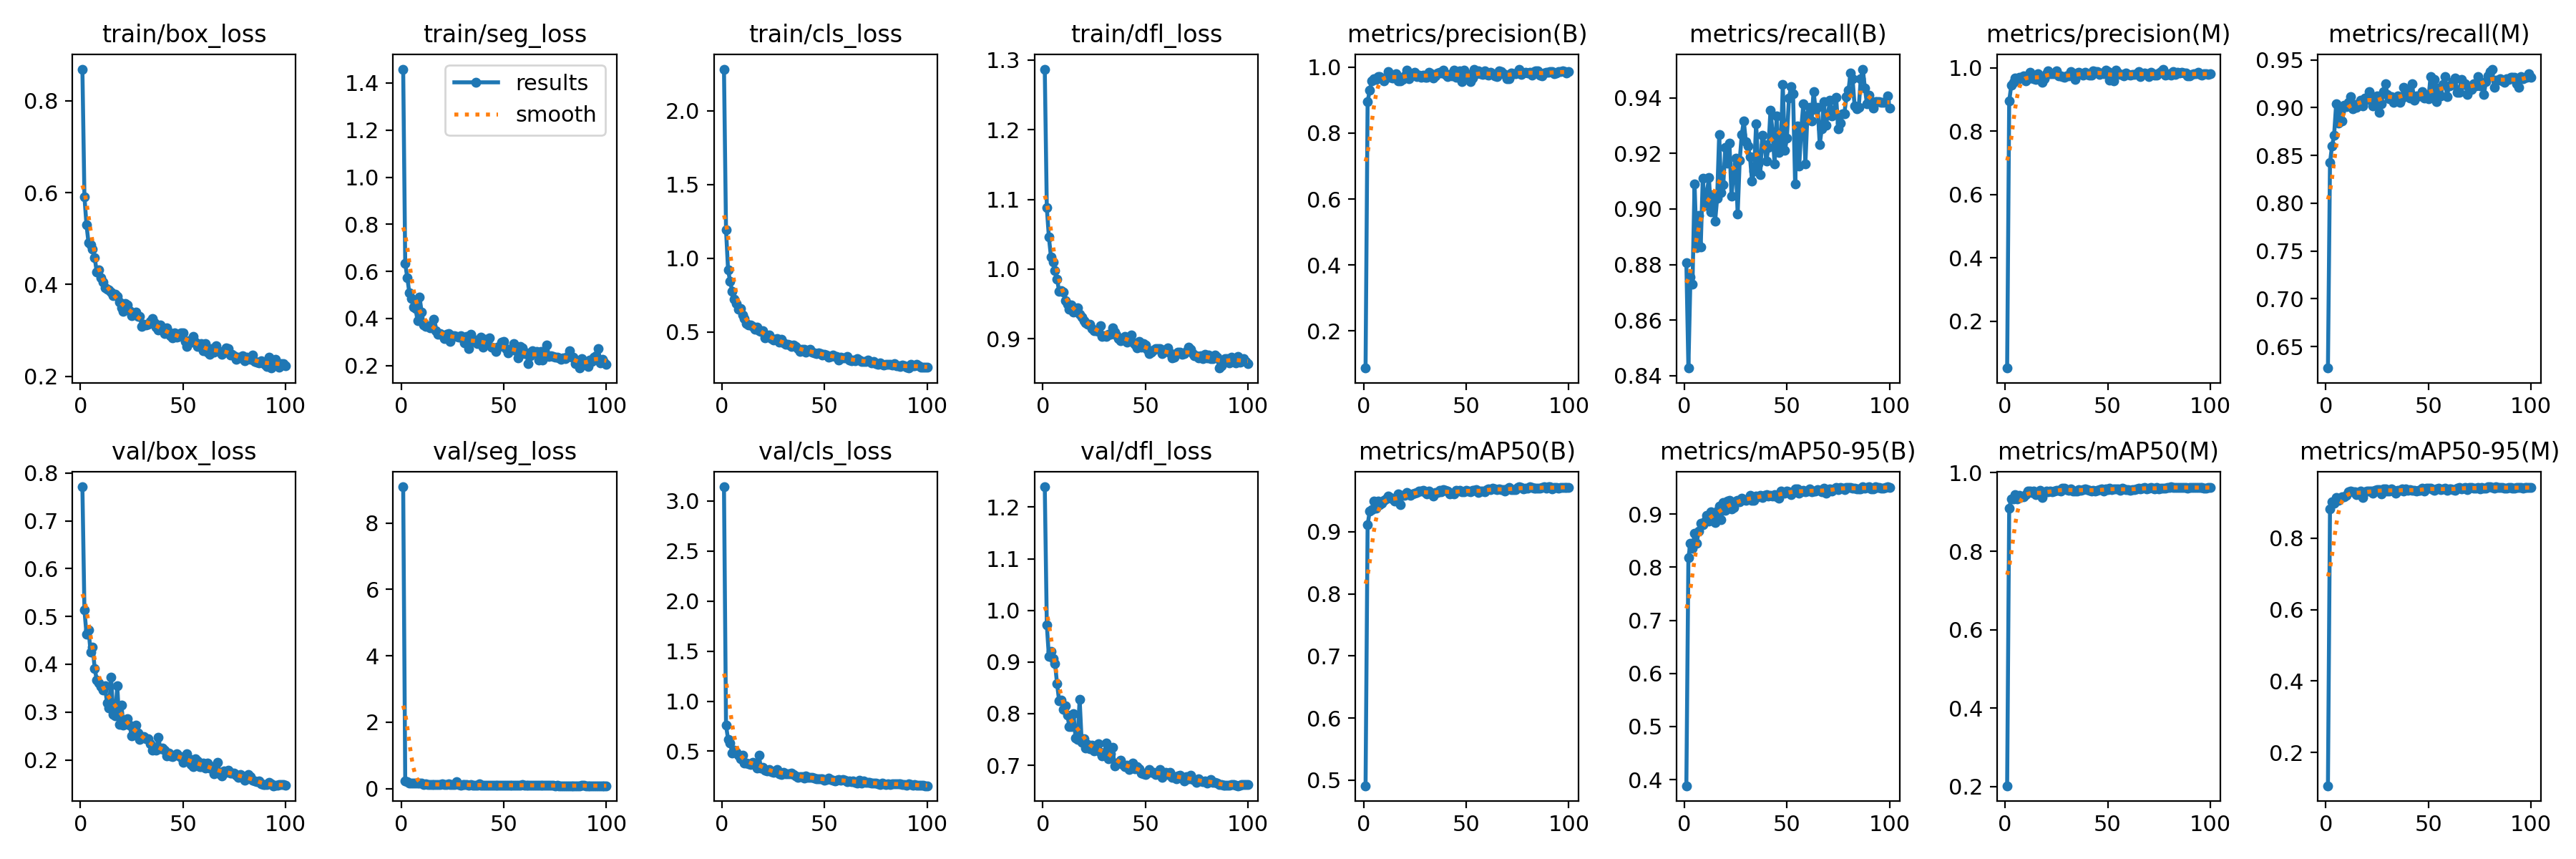

Mokymo rezultatų grafikas parodytas.


In [ ]:
#@title 6. Modelio mokymas
def train_road_type_model():
    """
    Mokome YOLOv8 segmentavimo modelį kelio dangos tipui klasifikuoti.
    Specialiai optimizuota tvirtam veikimui įvairiomis saulės šviesos sąlygomis
    su sustiprintu šviesumo/kontrasto augmentavimu ir specializuotais mokymo parametrais.
    """
    from ultralytics import YOLO
    import torch
    import glob
    import os
    import yaml
    import cv2
    import shutil
    import numpy as np
    from tqdm import tqdm
    import random
    import time
    import logging
    from IPython.display import display, Image

    # Nustatome bazinį žurnalo registravimą geresniam klaidų sekimui
    logging.basicConfig(level=logging.INFO,
                      format='%(asctime)s - %(levelname)s - %(message)s')
    logger = logging.getLogger('train_export')

    print("\nRuošiame kelio dangos segmentavimo mokymą su atsparumu saulės šviesai...")
    logger.info("Pradedamas kelio dangos segmentavimo mokymas su atsparumu saulės šviesai")

    # Bandome naudoti naujausius/greičiausius modelius, jei prieinami
    try:
        # Pirmiausia bandome YOLOv11n-seg, jei prieinamas (naujausias/greičiausias)
        logger.info("Bandoma įkelti YOLOv8n-seg modelį...")
        model = YOLO('yolov8n-seg.pt')
        initial_model_name = 'yolov8n-seg'
        logger.info("Sėkmingai įkeltas YOLO11n-seg modelis!")
    except Exception as e:
        logger.warning(f"YOLOv8n-seg neprieinamas: {str(e)}")
        try:
            # Bandome YOLOv10n-seg, jei prieinamas (antras pagal greitį)
            logger.info("Bandoma įkelti YOLOv10n-seg modelį...")
            model = YOLO('yolov10n-seg.pt')
            initial_model_name = 'yolov10n-seg'
            logger.info("Sėkmingai įkeltas YOLOv10n-seg modelis!")
        except:
            # Grįžtame prie YOLOv8n-seg (patikimos opcijos)
            logger.info("Grįžtama prie YOLOv8n-seg modelio")
            model = YOLO('yolov8n-seg.pt')
            initial_model_name = 'yolov8n-seg'

    # Užregistruojame, kurį modelį naudojame
    logger.info(f"Naudojamas modelis: {initial_model_name}")

    # Mokymo parametrai - optimizuoti atsparumui saulės šviesai
    epochs = 110    # Žymiai padidintas geresniam konvergavimui
    imgsz = 800     # Išlaikytas geram balansui
    batch_size = 12 # Išlaikytas geram balansui

    # Apibrėžiame augmentavimo nustatymus, orientuotus į apšvietimo variaciją
    aug_config = {
        'hsv_h': 0.2,      # Padidintas atspalvio keitimas
        'hsv_s': 0.7,      # Žymiai padidintas sotumas
        'hsv_v': 0.8,      # Labai padidintas šviesumas saulės šviesos apdorojimui
        'degrees': 10.0,   # Išlaikytas vidutinis pasukimas
        'translate': 0.15, # Išlaikytas vidutinis perkėlimas
        'scale': 0.2,      # Išlaikytas vidutinis mastelio keitimas
        'fliplr': 0.5,     # Standartinis horizontalus apvertimas
        'mosaic': 0.6,     # Padidintas mozaikos tikimybė
        'mixup': 0.3,      # Padidintas mixup geresniam apibendrinimui
        'copy_paste': 0.1, # Išlaikytas minimalus kopijavimas-įklijavimas
    }

    # Pradedame mokymą
    print(f"\nPradedame mokymą ant {'CUDA' if torch.cuda.is_available() else 'CPU'}")
    print(f"Vaizdo dydis: {imgsz}, Partijos dydis: {batch_size}, Epochos: {epochs}")


    logger.info(f"Pradedamas mokymas su {initial_model_name} modeliu")
    logger.info(f"Naudojamas įrenginys: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
    logger.info(f"Vaizdo dydis: {imgsz}, Partijos dydis: {batch_size}, Epochos: {epochs}")

    # Patikrinti, ar egzistuoja projekto direktorija
    if not os.path.exists(project_dir):
        os.makedirs(project_dir, exist_ok=True)
        logger.info(f"Sukurta projekto direktorija: {project_dir}")

    # Įsitikinti, kad exports_dir egzistuoja
    if not os.path.exists(exports_dir):
        os.makedirs(exports_dir, exist_ok=True)
        logger.info(f"Sukurta eksportavimo direktorija: {exports_dir}")

    # Įsitikinti, kad results_dir egzistuoja
    if not os.path.exists(results_dir):
        os.makedirs(results_dir, exist_ok=True)
        logger.info(f"Sukurta rezultatų direktorija: {results_dir}")

    try:
        # Slopinti išsamius pranešimus apmokymo metu
        import builtins
        original_print = builtins.print
        builtins.print = lambda *args, **kwargs: None

        results = model.train(
            data=dataset_yaml,
            epochs=epochs,
            imgsz=imgsz,
            batch=batch_size,
            patience=20,        # Toliau padidintas kantrumas geresniam konvergavimui
            save=True,
            project=project_dir,
            name='road_seg_model',
            save_period=10,     # Išsaugome kontrolinius taškus kas 10 epochų
            pretrained=True,
            optimizer='AdamW',  # AdamW optimizatorius geresniam apibendrinimui
            lr0=0.0002,         # Toliau sumažintas mokymosi greitis stabilesniam mokymui
            lrf=0.005,          # Žemesnis galutinis mokymosi greičio faktorius smulkioms detalėms
            weight_decay=0.0005,# L2 reguliarizacija
            augment=True,       # Įjungiame augmentavimą
            cache='ram',       # Pakeitimas iš 'ram' į 'disk'
            device=0 if torch.cuda.is_available() else 'cpu',
            plots=True,         # Generuojame grafikus
            cos_lr=True,        # Kosinuso LR planuoklis
            verbose=True,       # Rodome progresą
            task='segment',     # Užduoties tipas
            **aug_config
        )

        # Atkurti spausdinimo funkciją
        builtins.print = original_print
        logger.info("Apmokymas baigtas!")
        print("Mokymas baigtas!")

    except Exception as e:
        # Atkurti spausdinimo funkciją jei įvyksta klaida
        builtins.print = original_print
        logger.error(f"Klaida mokymo metu: {str(e)}")
        print(f"Klaida mokymo metu: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None, None

    # Palaukti momentą, kad failų sistemos operacijos būtų baigtos
    time.sleep(2)

    # Ieškome geriausio modelio
    best_model_path = os.path.join(project_dir, 'road_seg_model', 'weights', 'best.pt')

    if not os.path.exists(best_model_path):
        # Bandome rasti bet kokį .pt modelį
        potential_models = glob.glob(os.path.join(project_dir, 'road_seg_model', 'weights', '*.pt'))
        if potential_models:
            best_model_path = potential_models[0]
            logger.info(f"Geriausias modelis nerastas numatytame kelyje. Naudojamas rastas modelis: {best_model_path}")
            print(f"Naudojame alternatyvų modelį: {best_model_path}")
        else:
            logger.error("Nepavyko rasti apmokyto modelio. Patikrinkite išvesties direktorijas.")
            print("Modelio failai nerasti. Negalime tęsti.")
            return None, results, None

    logger.info(f"Naudojamas modelis: {best_model_path}")
    print(f"Naudojamas modelis: {best_model_path}")

    # Įkeliame geriausią modelį
    best_model = YOLO(best_model_path)

    # Naudojame pradinį modelio pavadinimą eksportams
    model_name = initial_model_name
    logger.info(f"Naudojamas modelio tipas eksportavimui: {model_name}")
    print(f"Naudojamas modelio tipas eksportavimui: {model_name}")

    # Vykdome validavimą su keliais pasitikėjimo slenksčiais atsparumo saulės šviesai testavimui
    logger.info("\nVykdomas validavimas...")
    print("\nVykdome validavimą...")
    try:
        # Standartinis validavimas
        val_results = best_model.val(
            data=dataset_yaml,
            split='val',
            imgsz=imgsz,
            batch=batch_size,
            plots=True,
            save_json=True,
            save_txt=True,
            project=results_dir,
            name='validation',
            task='segment'
        )

        # Spausdiname metrikas
        if hasattr(val_results, 'seg') and val_results.seg is not None:
            logger.info(f"Validavimo mAP50: {val_results.seg.map50:.4f}")
            print(f"Validavimo mAP50: {val_results.seg.map50:.4f}")

            if hasattr(val_results.seg, 'map'):
                logger.info(f"Validavimo mAP50-95: {val_results.seg.map:.4f}")
                print(f"Validavimo mAP50-95: {val_results.seg.map:.4f}")

            # Klasių specifinės metrikos
            if hasattr(val_results, 'seg_class') and val_results.seg_class is not None:
                print("\nKlasių specifinės metrikos:")
                yaml_content = yaml.safe_load(open(dataset_yaml))
                for cls_id, metrics in val_results.seg_class.items():
                    cls_name = yaml_content['names'].get(cls_id, f"Klasė {cls_id}")
                    print(f"  {cls_name}: mAP50 = {metrics['map50']:.4f}, Tikslumas = {metrics['precision']:.4f}, Jautrumas = {metrics['recall']:.4f}")

    except Exception as e:
        logger.error(f"Klaida validavimo metu: {str(e)}")
        print(f"Klaida validavimo metu: {str(e)}")
        print("Tęsiame eksportavimą...")
        val_results = None

    # Apibrėžti išvesties failų pavadinimus ir kelius
    pt_filename = f'road_type_seg_{model_name}.pt'
    onnx_filename = f'road_type_seg_{model_name}.onnx'
    pt_path = os.path.join(exports_dir, pt_filename)
    onnx_path = os.path.join(exports_dir, onnx_filename)

    # Eksportuojame modelius
    logger.info("\nEksportuojami modeliai...")
    print("\nEksportuojame modelius...")
    export_success = {'pt': False, 'onnx': False}

    try:
        # Eksportuoti į .pt formatą (PyTorch)
        shutil.copy(best_model_path, pt_path)
        logger.info(f"PyTorch modelis eksportuotas į: {pt_path}")
        print(f"PyTorch modelis eksportuotas į: {pt_path}")
        export_success['pt'] = True

        # Eksportuoti į ONNX formatą - patobulinta su detaliais parametrais
        logger.info("Eksportuojama į ONNX formatą su išsamiais parametrais...")
        print("Eksportuojama į ONNX formatą su išsamiais parametrais...")

        # Eksportuojame su detaliais parametrais geresniam suderinamumui
        best_model.export(
            format='onnx',
            imgsz=imgsz,        # Naudojame tą patį vaizdo dydį kaip mokymo metu
            simplify=True,      # Supaprastiname modelį
            opset=12,           # Naudojame ONNX opset 12 geresniam suderinamumui
            half=False,         # Nenaudojame pusės tikslumo problemoms išvengti
            int8=False,         # Nenaudojame int8 kvantizacijos
            dynamic=True,       # Leidžiame dinamišką partijos dydį
            verbose=True        # Rodome išsamią eksportavimo informaciją
        )

        # ONNX modeliai paprastai išsaugomi tame pačiame kataloge kaip PT modelis su .onnx plėtiniu
        default_onnx_path = os.path.splitext(best_model_path)[0] + '.onnx'

        # Jei nerandame, patikriname, ar jis buvo išsaugotas dabartiniame kataloge
        if not os.path.exists(default_onnx_path):
            for root, dirs, files in os.walk(project_dir):
                for file in files:
                    if file.endswith('.onnx'):
                        default_onnx_path = os.path.join(root, file)
                        break
                if default_onnx_path != os.path.splitext(best_model_path)[0] + '.onnx':
                    break

        if os.path.exists(default_onnx_path):
            # Naudojame kopijavimą, o ne perkėlimą, kad išsaugotume originalą
            shutil.copy(default_onnx_path, onnx_path)
            logger.info(f"ONNX modelis eksportuotas į: {onnx_path}")
            print(f"ONNX modelis eksportuotas į: {onnx_path}")
            export_success['onnx'] = True

            # Patikriname ONNX modelį, kad įsitikintume, jog jis veikia teisingai
            try:
                import onnx
                onnx_model = onnx.load(onnx_path)
                onnx.checker.check_model(onnx_model)
                logger.info("ONNX modelis sėkmingai patikrintas - teisingas formatas")
                print("ONNX modelis sėkmingai patikrintas - teisingas formatas")
            except Exception as e:
                logger.warning(f"ONNX modelio validavimo įspėjimas: {str(e)}")
                print(f"ONNX modelio validavimo įspėjimas: {str(e)}")
        else:
            logger.error(f"ONNX eksportavimas baigtas, bet failas nerastas: {default_onnx_path}")
            print(f"ONNX eksportavimas baigtas, bet failas nerastas: {default_onnx_path}")
            print("Bandoma alternatyvų eksportavimo metodą...")

            # Bandome alternatyvų eksportavimo metodą, jei pirmasis nepavyko
            try:
                # Tiesioginis eksportavimas į paskirties vietą
                best_model.export(
                    format='onnx',
                    imgsz=imgsz,
                    simplify=True,
                    opset=12,
                    half=False,
                    dynamic=True,
                    verbose=True,
                    file=onnx_path  # Tiesiogiai nurodome išvesties failą
                )

                if os.path.exists(onnx_path):
                    logger.info(f"ONNX modelis eksportuotas į: {onnx_path} (alternatyvus metodas)")
                    print(f"ONNX modelis eksportuotas į: {onnx_path} (alternatyvus metodas)")
                    export_success['onnx'] = True
            except Exception as e:
                logger.error(f"Alternatyvus ONNX eksportavimas nepavyko: {str(e)}")
                print(f"Alternatyvus ONNX eksportavimas nepavyko: {str(e)}")

    except Exception as e:
        logger.error(f"Klaida modelio eksportavimo metu: {str(e)}")
        print(f"Klaida modelio eksportavimo metu: {str(e)}")
        print(f"Eksportavimo klaidos detalės: {e.__class__.__name__}")
        import traceback
        traceback.print_exc()

    # Testuojame keletą prognozių su specialiu dėmesiu saulės šviesos apdorojimui
    print("\nVykdome testavimo prognozes...")
    try:
        # Gauname keletą testavimo vaizdų
        test_img_dir = os.path.join(dataset_root, 'images', 'test')
        test_images = os.listdir(test_img_dir)[:25]  # Testuojame 25 vaizdus

        for img_name in test_images:
            img_path = os.path.join(test_img_dir, img_name)

            # Originalaus vaizdo prognozė
            pred_results = best_model.predict(
                source=img_path,
                save=True,
                project=predictions_dir,
                name=f"pred_{os.path.splitext(img_name)[0]}",
                conf=0.25,
                task='segment'
            )

            # Taip pat testuojame su dirbtinai pašviesintu variantu, imituojančiu saulės šviesą
            try:
                img = cv2.imread(img_path)
                # Taikome gama korekciją saulės šviesos imitavimui
                gamma = 1.5  # Šviesumo didinimas
                inv_gamma = 1.0 / gamma
                table = [((i / 255.0) ** inv_gamma) * 255 for i in range(256)]
                table = np.array(table, np.uint8)
                bright_img = cv2.LUT(img, table)

                # Išsaugome pašviestintą vaizdą
                bright_img_path = os.path.join(predictions_dir, f"bright_{img_name}")
                cv2.imwrite(bright_img_path, bright_img)

                # Testuojame prognozę pašviestintam vaizdui
                pred_results_bright = best_model.predict(
                    source=bright_img_path,
                    save=True,
                    project=predictions_dir,
                    name=f"pred_bright_{os.path.splitext(img_name)[0]}",
                    conf=0.25,
                    task='segment'
                )

                print(f"Prognozė atlikta {img_name} (originaliam ir pašviestintam)")
            except Exception as e:
                print(f"Klaida pašviestintos prognozės metu: {str(e)}")
    except Exception as e:
        print(f"Klaida prognozės metu: {str(e)}")

    # Generuojame mokymo santrauką
    print("\n" + "="*50)
    print("KELIO TIPŲ SEGMENTAVIMO MOKYMO SANTRAUKA - ATSPARI SAULĖS ŠVIESAI VERSIJA")
    print("="*50)

    # Modelio detalės
    print(f"Modelis: {model_name} su svertiniais paviršiaus tipo duomenimis")
    print(f"Klasės: asfaltas (0), žvyras (1), grindinys (2)")
    print(f"Paveikslėlio dydis: {imgsz}x{imgsz}")
    print(f"Mokymo epochos: {epochs}")
    print(f"Ankstyvo sustabdymo kantrybė: 20")
    print(f"Pradinis mokymosi greitis: 0.0002")
    print(f"Svorio mažinimas: 0.0005")
    print(f"Paketo dydis: {batch_size}")
    print(f"Augmentacijos fokusas: EKSTREMALUS ryškumo kitimas (hsv_v={aug_config['hsv_v']}) atsparumui saulės šviesai")
    print(f"Sodrumo kitimas: hsv_s={aug_config['hsv_s']} (pagerintas situacijoms su saulės šviesa)")
    print(f"Papildomas apšvietimo apdorojimas: Taip (gama korekcija ant dalies mokymo duomenų)")


    # Apmokymo našumas
    if hasattr(results, 'metrics') and results.metrics is not None:
        if hasattr(results.metrics, 'fitness') and results.metrics.fitness is not None:
            print(f"Galutinis tinkamumo balas: {results.metrics.fitness:.4f}")

    # Duomenų rinkinio informacija
    print(f"Duomenų rinkinys: Iš viso panaudota {sum(class_counts.values())} paveikslėlių (visi duomenys)")
    for surface_type, count in class_counts.items():
        print(f"  - {surface_type}: {count} paveikslėliai")

    # Tinkamai patikrinti segmentacijos metrikas
    if hasattr(results, 'seg'):
        print(f"Segmentacijos našumas:")
        if hasattr(results.seg, 'map50'):
            print(f"  mAP50: {results.seg.map50:.4f}")
        if hasattr(results.seg, 'map'):
            print(f"  mAP50-95: {results.seg.map:.4f}")
        if hasattr(results.seg, 'precision'):
            print(f"  Tikslumas: {results.seg.precision:.4f}")
        if hasattr(results.seg, 'recall'):
            print(f"  Atšaukimas: {results.seg.recall:.4f}")

    # Validavimo našumas
    if val_results is not None and hasattr(val_results, 'seg'):
        print("\nValidavimo našumas:")
        if hasattr(val_results.seg, 'map50'):
            print(f"  Segmentacijos mAP50: {val_results.seg.map50:.4f}")
        if hasattr(val_results.seg, 'map'):
            print(f"  Segmentacijos mAP50-95: {val_results.seg.map:.4f}")
        if hasattr(val_results.seg, 'precision'):
            print(f"  Segmentacijos tikslumas: {val_results.seg.precision:.4f}")
        if hasattr(val_results.seg, 'recall'):
            print(f"  Segmentacijos atšaukimas: {val_results.seg.recall:.4f}")

    # Eksportavimo informacija
    print("\nEksportuoti modeliai:")
    if export_success['pt']:
        print(f"  PyTorch (.pt): {pt_path}")
    if export_success['onnx']:
        print(f"  ONNX (.onnx): {onnx_path}")

    print("\nRezultatai išsaugoti:")
    print(f"  Projekto direktorija: {project_dir}")
    print(f"  Apmokymo grafikai: {os.path.join(project_dir, 'road_seg_model')}")
    print(f"  Validavimo rezultatai: {os.path.join(results_dir, 'validation')}")
    print(f"  Prognozių rezultatai: {predictions_dir}")
    print("="*50)

    # Rodyti grafikus, jei yra
    try:
        results_plots = os.path.join(project_dir, 'road_seg_model', 'results.png')
        if os.path.exists(results_plots):
            display(Image(results_plots))
            print("Mokymo rezultatų grafikas parodytas.")
    except:
        pass

    return best_model, results, val_results

# Vykdyti mokymo funkciją
best_model, training_results, validation_results = train_road_type_model()